In [6]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set(style="whitegrid")

In [7]:
# %load models.py
import numpy as np
import scipy.stats as stats
import patsy
import sklearn.linear_model as linear
import random
import pandas as pd

from IPython.display import HTML

def linear_regression(formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices(formula, data, return_type="matrix")
    model = linear.LinearRegression(fit_intercept=False).fit( X, y)

    result["coefficients"] = model.coef_[ 0]

    result["r_squared"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result["residuals"] = y - y_hat
    
    sum_squared_error = sum([e**2 for e in result[ "residuals"]])[0]

    n = len(result["residuals"])
    k = len(result["coefficients"])
    
    result["sigma"] = np.sqrt( sum_squared_error / (n - k))
    
    return result

def logistic( z):
    return 1.0 / (1.0 + np.exp( -z))

def logistic_regression( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    y = np.ravel( y) # not sure why this is needed for LogisticRegression but not LinearRegression

    model = linear.LogisticRegression( fit_intercept=False).fit( X, y)
    result["model"] = model

    result[ "coefficients"] = model.coef_[ 0]

    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat

    # efron's pseudo R^2
    y_bar = np.mean(y)
    pr = model.predict_proba(X).transpose()[1]
    result["probabilities"] = pr
    efrons_numerator = np.sum((y - pr)**2) 
    efrons_denominator = np.sum((y-y_bar)**2)
    result["r_squared"] = 1 - (efrons_numerator/efrons_denominator)

    # error rate
    result["error"] = np.sum(np.abs(result["residuals"]))/result["n"]*100

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])

    return result

def simple_describe_lr(fit):
    results = r"""
    <table>
    <tr><th> model </th><td> {formula} </td></tr>
    <tr><th colspan=2>coefficients</th></tr>
    """.format(**fit)

    results += r"<tr><th> $\beta_0$ </th><td> {0} </td></tr>".format(fit["coefficients"][0])

    variables = fit["formula"].split("~")[1].split( "+")
    for i, b in enumerate(zip(variables, fit["coefficients"][1:])):
        results += r"<tr><td> {1} ($\beta_{0}$) </td><td> {2} </td></tr>".format(i + 1, b[0], b[1])

    results += r"""
    <tr><th colspan=2>metrics</th></tr>
    <tr><td> $\sigma$ </td><td> {sigma} </td></tr>
    <tr><td> $R^2$ </td><td> {r_squared} </td></tr>
    </table>
    """.format(**fit)
    return HTML(results)

def simple_describe_lgr(fit):
    results = r"""
    <table>
    <tr><th> model </th><td> {formula} </td></tr>
    <tr><th colspan=2>coefficients</th></tr>
    """.format(**fit)

    results += r"<tr><th> $\beta_0$ </th><td> {0} </td></tr>".format(fit["coefficients"][0])

    variables = fit["formula"].split("~")[1].split( "+")
    for i, b in enumerate(zip(variables, fit["coefficients"][1:])):
        results += r"<tr><td> {1} ($\beta_{0}$) </td><td> {2} </td></tr>".format(i + 1, b[0], b[1])

    results += r"""
    <tr><th colspan=2>metrics</th></tr>
    <tr><td> Error (%) </td><td> {error} </td></tr>
    <tr><td> $R^2$ </td><td> {r_squared} </td></tr>
    </table>
    """.format(**fit)
    return HTML(results)

def bootstrap_linear_regression( formula, data=None, samples=100):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = [x.strip() for x in formula.split("~")[1].split( "+")]
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables
    
    coeffs = []
    sigmas = []
    rs = []

    n = data.shape[ 0]
    bootstrap_results[ "n"] = n
    
    for i in range( samples):
        sampling_indices = [ i for i in [random.randint(0, n - 1) for _ in range( 0, n)]]
        sampling = data.loc[ sampling_indices]
        
        results = linear_regression( formula, data=sampling)
        coeffs.append( results[ "coefficients"])
        sigmas.append( results[ "sigma"])
        rs.append( results[ "r_squared"])
    
    coeffs = pd.DataFrame( coeffs, columns=variables)
    sigmas = pd.Series( sigmas, name="sigma")
    rs = pd.Series( rs, name="r_squared")

    bootstrap_results[ "resampled_coefficients"] = coeffs
    bootstrap_results[ "resampled_sigma"] = sigmas
    bootstrap_results[ "resampled_r^2"] = rs
    
    result = linear_regression( formula, data=data)
    
    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    bootstrap_results[ "sigma"] = result[ "sigma"]
    bootstrap_results[ "r_squared"] = result[ "r_squared"]
    return bootstrap_results

def bootstrap_logistic_regression( formula, data=None, samples=100):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = [x.strip() for x in formula.split("~")[1].split( "+")]
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables
    
    coeffs = []
    sigmas = []
    rs = []

    n = data.shape[ 0]
    bootstrap_results[ "n"] = n
    
    for i in range( samples):
        sampling_indices = [ i for i in [random.randint(0, n - 1) for _ in range( 0, n)]]
        sampling = data.loc[ sampling_indices]
        
        results = logistic_regression( formula, data=sampling)
        coeffs.append( results[ "coefficients"])
        sigmas.append( results[ "error"])
        rs.append( results[ "r_squared"])
    
    coeffs = pd.DataFrame( coeffs, columns=variables)
    sigmas = pd.Series( sigmas, name="sigma")
    rs = pd.Series( rs, name="r_squared")

    bootstrap_results[ "resampled_coefficients"] = coeffs
    bootstrap_results[ "resampled_error"] = sigmas
    bootstrap_results[ "resampled_r^2"] = rs
    
    result = logistic_regression( formula, data=data)
    
    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    bootstrap_results[ "error"] = result[ "error"]
    bootstrap_results[ "r_squared"] = result[ "r_squared"]
    return bootstrap_results

def describe_bootstrap_lr(fit, significant_digits=2):
    sd = significant_digits
    results = r"""
    <table>
    <tr><th> model </th><td> {formula} </td></tr>
    <tr><th colspan=2>coefficients</th><th>95% BCI</th></tr>
    """.format(**fit)

    bounds = fit[ "resampled_coefficients"].quantile([0.025, 0.975])
    bounds = bounds.transpose()
    bounds = bounds.values.tolist()

    results += (r"<tr><th> $\beta_0$ </th><td> {0:." + 
        str(sd) + r"f} </td><td>({1:." +
        str(sd) + r"f}, {2:." + str(sd) + "f})</td></tr>").format(fit["coefficients"][0], bounds[0][0], bounds[0][1])

    variables = fit["formula"].split("~")[1].split( "+")
    for i, b in enumerate(zip(variables, fit["coefficients"][1:], bounds[1:])):
        results += (r"<tr><td> {1} ($\beta_{0}$) </td><td> {2:." +
            str(sd) + r"f} </td><td>({3:." + 
            str(sd) + r"f}, {4:." +
            str(sd) + r"f})</tr>").format(i + 1, b[0], b[1], b[2][0], b[2][1])

    sigma_bounds = stats.mstats.mquantiles( fit[ "resampled_sigma"], [0.025, 0.975])
    r_bounds = stats.mstats.mquantiles( fit[ "resampled_r^2"], [0.025, 0.975])

    results += r"<tr><th colspan=2>metrics</th><th>95% BCI</th></tr>"
    results += (r"<tr><th> $\sigma$ </th><td> {0:." +
         str(sd) + r"f} </td><td>({1:." +
         str(sd) + r"f}, {2:." +
         str(sd) + r"f}) </td></tr>").format(fit["sigma"], sigma_bounds[0], sigma_bounds[1])
    results += (r"<tr><th> $R^2$ </th><td> {0:." +
         str(sd) + r"f} </td><td>({1:." + 
         str(sd) + r"f}, {2:." +
         str(sd) + r"f})</td></tr>").format(fit["r_squared"], r_bounds[0], r_bounds[1])
    results += r"</table>"
    return HTML(results)

def describe_bootstrap_lgr(fit, significant_digits=2):
    sd = significant_digits
    results = r"""
    <table>
    <tr><th> model </th><td> {formula} </td></tr>
    <tr><th colspan=2>coefficients</th><th>95% BCI</th><th>P(y=1)</th></tr>
    """.format(**fit)

    bounds = fit[ "resampled_coefficients"].quantile([0.025, 0.975])
    bounds = bounds.transpose()
    bounds = bounds.values.tolist()

    results += (r"<tr><th> $\beta_0$ </th><td> {0:." + 
        str(sd) + r"f} </td><td>({1:." +
        str(sd) + r"f}, {2:." + 
        str(sd) + r"f})</td><td>{3:." +
        str(sd) + r"f}</td></tr>"
        ).format(fit["coefficients"][0], bounds[0][0], bounds[0][1], logistic(fit["coefficients"][0]))

    variables = fit["formula"].split("~")[1].split( "+")
    for i, b in enumerate(zip(variables, fit["coefficients"][1:], bounds[1:])):
        results += (r"<tr><td> {1} ($\beta_{0}$) </td><td> {2:." +
            str(sd) + r"f} </td><td>({3:." + 
            str(sd) + r"f}, {4:." +
            str(sd) + r"f})</td><td>{5:." +
            str(sd) + r"f}</td></tr>").format(i + 1, b[0], b[1], b[2][0], b[2][1], b[1]/4)

    sigma_bounds = stats.mstats.mquantiles( fit[ "resampled_error"], [0.025, 0.975])
    r_bounds = stats.mstats.mquantiles( fit[ "resampled_r^2"], [0.025, 0.975])

    results += r"<tr><th colspan=2>metrics</th><th>95% BCI</th></tr>"
    results += (r"<tr><td> Error (%) </td><td> {0:." +
         str(sd) + r"f} </td><td>({1:." +
         str(sd) + r"f}, {2:." +
         str(sd) + r"f}) </td></tr>").format(fit["error"], sigma_bounds[0], sigma_bounds[1])
    results += (r"<tr><th> $R^2$ </th><td> {0:." +
         str(sd) + r"f} </td><td>({1:." + 
         str(sd) + r"f}, {2:." +
         str(sd) + r"f})</td></tr>").format(fit["r_squared"], r_bounds[0], r_bounds[1])
    results += r"</table>"
    return HTML(results)


p = 0.6
beta_0 = 1
beta_1 = 2
beta_2 = 3
beta_3 = 4
50


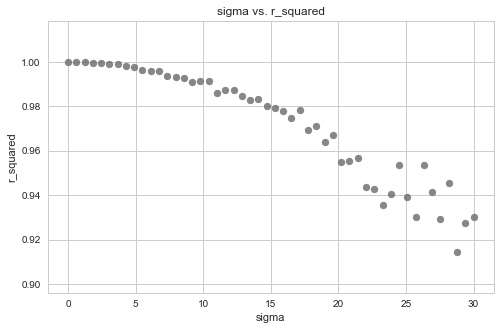

In [9]:
np.random.seed(3)


data = {}

data["x1"] = stats.norm.rvs(50.0, 1, 100)

p = 0.6
data["x2"] = [1 if np.random.rand() < p else 0 for _ in range(100)]
data["x2"] = np.array(data["x2"])
print("p = " + str(p))


beta_0 = 1
print("beta_0 = " + str(beta_0))
beta_1 = 2
print("beta_1 = " + str(beta_1))
beta_2 = 3
print("beta_2 = " + str(beta_2))
beta_3 = 4
print("beta_3 = " + str(beta_3))

sigma = np.linspace(0, 30)
print(len(sigma))
r_squared = []
for i in sigma:
    data["e"] = stats.norm.rvs(0, i, 100)
    data["y"] = beta_0 + beta_1 * data["x1"] + beta_2 * data["x2"] + beta_3 * data["x1"] * data["x2"] + data["e"]
    data = pd.DataFrame(data)
    model = bootstrap_linear_regression("y ~ x1 + x2 + x1:x2", data)
    r_squared.append(model["r_squared"])


figure = plt.figure(figsize = (8, 5))
axes = figure.add_subplot(1, 1, 1)
axes.scatter(sigma, r_squared, color = "dimgray", alpha = 0.8)
axes.set_title("sigma vs. r_squared")
axes.set_xlabel("sigma")
axes.set_ylabel("r_squared")
plt.show()
plt.close()
describe_bootstrap_lr(model)